In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

In [ ]:
df_phone_dataset = pd.read_csv('phone_dataset.csv')
PHONE_COUNT = len(df_phone_dataset)

In [ ]:
pd_1 = pd.read_csv('user_clicks_1_brand.csv')
pd_2 = pd.read_csv('user_ratings.csv')

MIN_USER_ID = min(pd_1['user_id'].min(), pd_2['user_id'].min())
MAX_USER_ID = max(pd_1['user_id'].max(), pd_2['user_id'].max())
TOTAL_USER = MAX_USER_ID - MIN_USER_ID + 1

##Preprocess Dataset

### Preprocess Dataset User Clicks

In [ ]:
df_user_clicks = pd.read_csv('user_clicks.csv')
df_user_clicks.head()

,user_id,phone_id,visit_time
0,1,15,2024-05-25 10:42:55
1,1,2,2024-05-25 10:42:55
2,1,3,2024-05-25 10:42:55
3,1,7,2024-05-25 10:42:55
4,1,14,2024-05-25 10:42:55


In [ ]:
df_user_clicks = df_user_clicks.sort_values(by='visit_time', ascending=False)
df_user_clicks = df_user_clicks.drop_duplicates(subset=['user_id', 'phone_id'], keep='first')
df_user_clicks = df_user_clicks.groupby('user_id').head(20)
df_user_clicks = df_user_clicks.reset_index(drop=True)
df_user_clicks.head(5)

,user_id,phone_id,visit_time
0,1500,58,2024-05-25 10:47:38
1,1500,53,2024-05-25 10:47:38
2,1500,21,2024-05-25 10:47:38
3,1500,94,2024-05-25 10:47:38
4,1500,19,2024-05-25 10:47:38


In [ ]:
user_counts = df_user_clicks['user_id'].value_counts()
users_with_count_gt_20 = user_counts[user_counts > 20]
len(users_with_count_gt_20.head())

0

In [ ]:
# Identify missing user IDs
missing_user_ids = set(range(MIN_USER_ID, MAX_USER_ID + 1)) - set(df_user_clicks['user_id'])

# Create a DataFrame with missing user IDs and clicks initialized to 0
missing_data = pd.DataFrame({'user_id': list(missing_user_ids), 'phone_id': -1, 'visit_time': '2024-01-01 00:00:00'})

# Append the missing data to the original DataFrame
df_user_clicks_complete = pd.concat([df_user_clicks, missing_data], ignore_index=True)

# Sort by user_id to maintain order
df_user_clicks_complete = df_user_clicks_complete.sort_values(by='user_id').reset_index(drop=True)

In [ ]:
train_clicks = df_user_clicks_complete[['user_id', 'phone_id']].pivot_table(index='phone_id', columns='user_id', aggfunc=lambda x: 1 if len(x) > 0 else 0, fill_value=0)
if len(missing_user_ids) > 0:
    train_clicks = train_clicks[1:]
train_clicks.head(96)


user_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1491.0,1492.0,1493.0,1494.0,1495.0,1496.0,1497.0,1498.0,1499.0,1500.0
phone_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
5,0,1,0,0,1,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,0,0,0,0,0,1,0,1,...,0,0,1,0,1,1,0,0,0,0
93,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,1,1,0,0,0
94,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1


###Preprocess Dataset User Ratings

In [ ]:
df_user_ratings = pd.read_csv("user_ratings.csv")
df_user_ratings.head()

,user_id,phone_id,rating,rate_time
0,1,9,5,2024-05-31 15:54:16
1,1,8,4,2024-05-31 15:54:16
2,1,11,5,2024-05-31 15:54:16
3,1,12,4,2024-05-31 15:54:16
4,1,7,4,2024-05-31 15:54:16


In [ ]:
df_user_ratings.drop_duplicates(inplace=True)
df_user_ratings.duplicated().sum()

0

In [ ]:
df_user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    10000 non-null  int64 
 1   phone_id   10000 non-null  int64 
 2   rating     10000 non-null  int64 
 3   rate_time  10000 non-null  object
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


In [ ]:
df_user_ratings = df_user_ratings.sort_values(by='rate_time', ascending=False)
df_user_ratings = df_user_ratings.drop_duplicates(subset=['user_id', 'phone_id'], keep='first')
df_user_ratings = df_user_ratings.groupby('user_id').head(20)
df_user_ratings = df_user_ratings.reset_index(drop=True)

In [ ]:
# Identify missing user IDs
missing_user_ids = set(range(MIN_USER_ID, MAX_USER_ID + 1)) - set(df_user_ratings['user_id'])

# Create a DataFrame with missing user IDs and clicks initialized to 0
missing_data = pd.DataFrame({'user_id': list(missing_user_ids), 'phone_id': -1, 'rating': 0})
missing_data['user_id'] = missing_data['user_id'].astype(int)
# Append the missing data to the original DataFrame
df_user_ratings_complete = pd.concat([df_user_ratings, missing_data], ignore_index=True)

# Sort by user_id to maintain order
df_user_ratings_complete = df_user_ratings_complete.sort_values(by='user_id').reset_index(drop=True)

In [ ]:
train_ratings = df_user_ratings_complete[['user_id', 'phone_id']].pivot_table(index='phone_id', columns='user_id', aggfunc=lambda x: 1 if len(x) > 0 else 0, fill_value=0)
if len(missing_user_ids) > 0:
    train_ratings = train_ratings[1:]
train_ratings.head(96)

user_id,1,2,3,4,5,6,7,8,9,10,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500
phone_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_ratings = df_user_ratings_complete.pivot(index='phone_id', columns='user_id', values='rating').fillna(0)
# train_ratings = train_ratings.astype(int)
if len(missing_user_ids) > 0:
    train_ratings = train_ratings[1:]
train_ratings.head(PHONE_COUNT)

user_id,1,2,3,4,5,6,7,8,9,10,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500
phone_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,4.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4.0,4.0,5.0,0.0,0.0,0.0,4.0,5.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Collaborative filtering learning algorithm

### Functional Untuk User Rating

In [ ]:
# Ynorm = train_ratings / 5.0

In [ ]:
def collaborative_model_ratings_functional(num_features):
    phone_input = tf.keras.Input(shape=(PHONE_COUNT,), dtype=tf.int32, name='phone_input')
    X = tf.keras.layers.Dense(units=num_features, activation=None, kernel_initializer='random_normal', name='X')(phone_input)
    output = tf.keras.layers.Dense(PHONE_COUNT, activation='softmax')(X)
    model = tf.keras.Model(inputs=phone_input, outputs=output, name='collaborative_model_ratings')
    return model

In [ ]:
model = collaborative_model_ratings_functional(100)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
phone_data = train_ratings.to_numpy().T

print(phone_data.shape)
model.fit(phone_data, phone_data, epochs=30, batch_size=32)

(1500, 96)
Epoch 1/30
47/47 [==============================] - 1s 2ms/step - loss: 1.2716 - accuracy: 0.0800
Epoch 2/30
47/47 [==============================] - 0s 2ms/step - loss: 1.2368 - accuracy: 0.1307
Epoch 3/30
47/47 [==============================] - 0s 3ms/step - loss: 1.2320 - accuracy: 0.2680
Epoch 4/30
47/47 [==============================] - 0s 2ms/step - loss: 1.2296 - accuracy: 0.3307
Epoch 5/30
47/47 [==============================] - 0s 2ms/step - loss: 1.2279 - accuracy: 0.3787
Epoch 6/30
47/47 [==============================] - 0s 2ms/step - loss: 1.2268 - accuracy: 0.3967
Epoch 7/30
47/47 [==============================] - 0s 2ms/step - loss: 1.2262 - accuracy: 0.3800
Epoch 8/30
47/47 [==============================] - 0s 2ms/step - loss: 1.2256 - accuracy: 0.4067
Epoch 9/30
47/47 [==============================] - 0s 2ms/step - loss: 1.2251 - accuracy: 0.4120
Epoch 10/30
47/47 [==============================] - 0s 2ms/step - loss: 1.2246 - accuracy: 0.4047
Epoch 11

In [ ]:
data = [0 for i in range(96)]
for i in range(0, 10):
    data[i] = 3
for i in range(60, 66):
    data[i] = 5


tes = np.array(data)
tes = np.reshape(tes, (1,PHONE_COUNT))
# tesnorm = tes / 5.0
result = model.predict(tes)

1/1 [==============================] - 0s 78ms/step


In [ ]:
index = 1
check_user = 0

probability = result[check_user]
data_user_rating = data
for i in range(PHONE_COUNT):
    if True:
        name =  df_phone_dataset.iloc[i]['name']
        id =  df_phone_dataset.iloc[i]['id']
        print(f'{index}. Probability rating {probability[i]:0.5f} for phone { name } id { id }')
        index += 1
    else:
        probability[i] = 0

1. Probability rating 0.00000 for phone Oppo Reno 11 Pro id 1
2. Probability rating 0.00000 for phone Oppo Reno 11 id 2
3. Probability rating 0.00000 for phone Oppo Reno 11F id 3
4. Probability rating 0.00046 for phone Oppo Reno 10 id 4
5. Probability rating 0.00000 for phone Oppo Reno 10 Pro id 5
6. Probability rating 0.08153 for phone Oppo Reno 10 Pro+ id 6
7. Probability rating 0.53588 for phone Oppo Find X7 Ultra id 7
8. Probability rating 0.00000 for phone Oppo Find X7 id 8
9. Probability rating 0.00000 for phone Oppo A98 5G id 9
10. Probability rating 0.00000 for phone Oppo A60 id 10
11. Probability rating 0.00000 for phone Oppo Find N3 id 11
12. Probability rating 0.00000 for phone Oppo A79 id 12
13. Probability rating 0.00000 for phone Oppo A18 id 13
14. Probability rating 0.00000 for phone Oppo A38 id 14
15. Probability rating 0.00000 for phone Oppo Pad Neo id 15
16. Probability rating 0.00000 for phone Asus Zenfone 11 Ultra id 16
17. Probability rating 0.00000 for phone Asus 

In [ ]:
df_result = pd.DataFrame()
df_result['probability'] = np.reshape(result[check_user], 96).astype(float)
df_result['name'] = df_phone_dataset['name']
sorted_df_result = df_result.sort_values(by='probability', ascending=False)
# sorted_df_result = sorted_df_result[sorted_df_result['probability'] <= 0.7]
sorted_df_result['probability'] = sorted_df_result['probability'] / sorted_df_result['probability'].max()
datas = sorted_df_result.to_numpy()
for i in range(10):
    prob = datas[i][0]
    print(f'{i + 1}. Recommending rating {prob:0.2f} for phone { (datas[i][1]) }')

1. Recommending rating 1.00 for phone Oppo Find X7 Ultra
2. Recommending rating 0.66 for phone iPhone 14 Pro
3. Recommending rating 0.15 for phone Oppo Reno 10 Pro+
4. Recommending rating 0.06 for phone iPhone 12
5. Recommending rating 0.00 for phone Oppo Reno 10
6. Recommending rating 0.00 for phone iPhone 15 Pro Max
7. Recommending rating 0.00 for phone iPhone 14
8. Recommending rating 0.00 for phone Huawei Pura 70 Ultra
9. Recommending rating 0.00 for phone Samsung Galaxy A35
10. Recommending rating 0.00 for phone iPhone 15 Pro


In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Functional Untuk User Click

In [ ]:
def collaborative_model_clicks_functional(num_features):


    phone_input = tf.keras.Input(shape=(PHONE_COUNT,), dtype=tf.int32, name='phone_input')
    X = tf.keras.layers.Dense(units=num_features, activation=None, kernel_initializer='random_normal', name='X')(phone_input)



    output = tf.keras.layers.Dense(PHONE_COUNT, activation='sigmoid')(X)

    # Define the model
    model = tf.keras.Model(inputs=phone_input, outputs=output, name='collaborative_model_clicks')


    return model

In [ ]:
model = collaborative_model_clicks_functional(100)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
user_data = np.array([i for i in range(TOTAL_USER)])
phone_data = train_clicks.to_numpy().T

print(phone_data.shape)
model.fit(phone_data, train_clicks.to_numpy().T, epochs=100, batch_size=32)

(1500, 96)
Epoch 1/100
47/47 [==============================] - 1s 2ms/step - loss: 0.1854 - accuracy: 0.0393
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1422 - accuracy: 0.0353
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1291 - accuracy: 0.0400
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1150 - accuracy: 0.0440
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1007 - accuracy: 0.0480
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.0500
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.0467
Epoch 8/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0606 - accuracy: 0.0480
Epoch 9/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0502 - accuracy: 0.0507
Epoch 10/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0414 - accuracy: 0.049

In [ ]:
data = [0 for i in range(96)]
# for i in range(52, 58):
#     data[i] = 1
for i in range(60, 66):
    data[i] = 1


tes = np.array(data)
tes = np.reshape(tes, (1,PHONE_COUNT))
result = model.predict(tes)

1/1 [==============================] - 0s 54ms/step


In [ ]:
index = 1
check_user = 0

probability = result[check_user]
data_user_clicked = data
for i in range(PHONE_COUNT):
    if data_user_clicked[i] != 1:
        name =  df_phone_dataset.iloc[i]['name']
        id =  df_phone_dataset.iloc[i]['id']
        print(f'{index}. Probability clicking {probability[i]:0.5f} for phone { name } id { id }')
        index += 1
    else:
        probability[i] = 0

1. Probability clicking 0.28282 for phone Oppo Reno 11 Pro id 1
2. Probability clicking 0.12709 for phone Oppo Reno 11 id 2
3. Probability clicking 0.15053 for phone Oppo Reno 11F id 3
4. Probability clicking 0.07396 for phone Oppo Reno 10 id 4
5. Probability clicking 0.06567 for phone Oppo Reno 10 Pro id 5
6. Probability clicking 0.14715 for phone Oppo Reno 10 Pro+ id 6
7. Probability clicking 0.12366 for phone Oppo Find X7 Ultra id 7
8. Probability clicking 0.18220 for phone Oppo Find X7 id 8
9. Probability clicking 0.20715 for phone Oppo A98 5G id 9
10. Probability clicking 0.12923 for phone Oppo A60 id 10
11. Probability clicking 0.07312 for phone Oppo Find N3 id 11
12. Probability clicking 0.04904 for phone Oppo A79 id 12
13. Probability clicking 0.14283 for phone Oppo A18 id 13
14. Probability clicking 0.04265 for phone Oppo A38 id 14
15. Probability clicking 0.02585 for phone Oppo Pad Neo id 15
16. Probability clicking 0.19756 for phone Asus Zenfone 11 Ultra id 16
17. Probabilit

In [ ]:
df_result = pd.DataFrame()
df_result['probability'] = np.reshape(result[check_user], 96).astype(float)
df_result['name'] = df_phone_dataset['name']
sorted_df_result = df_result.sort_values(by='probability', ascending=False)
# sorted_df_result = sorted_df_result[sorted_df_result['probability'] <= 0.7]
sorted_df_result['probability'] = sorted_df_result['probability'] / sorted_df_result['probability'].max()
datas = sorted_df_result.to_numpy()
for i in range(10):
    prob = datas[i][0]
    print(f'{i + 1}. Recommending clicking {prob:0.2f} for phone { (datas[i][1]) }')

1. Recommending clicking 1.00 for phone Vivo Y18
2. Recommending clicking 0.83 for phone Huawei Pura 70 Ultra
3. Recommending clicking 0.76 for phone Xiaomi 14
4. Recommending clicking 0.72 for phone Oppo Reno 11 Pro
5. Recommending clicking 0.66 for phone Samsung Galaxy A25
6. Recommending clicking 0.65 for phone iPhone 15 Pro
7. Recommending clicking 0.64 for phone Huawei Nova 12 SE
8. Recommending clicking 0.57 for phone Samsung Galaxy Z Fold5
9. Recommending clicking 0.57 for phone Poco X6 Pro 5G
10. Recommending clicking 0.55 for phone Huawei Nova 11 Pro


### Combine Model


In [ ]:
def combine_collaborative_model(num_features):
    click_input = tf.keras.Input(shape=(PHONE_COUNT,), dtype=tf.int32, name='click_input')
    rating_input = tf.keras.Input(shape=(PHONE_COUNT,), dtype=tf.int32, name='rating_input')
    X = tf.keras.layers.Concatenate(name='concatenated_inputs')([rating_input, click_input])
    X = tf.keras.layers.Dense(units=num_features, activation=None, kernel_initializer='random_normal', name='X')(X)
    # output_rating = tf.keras.layers.Dense(PHONE_COUNT, activation='softmax', name='output_rating')(X)
    output_click = tf.keras.layers.Dense(PHONE_COUNT, activation='sigmoid', name='output')(X)
    model = tf.keras.Model(inputs=[rating_input, click_input], outputs=output_click, name='collaborative_model')
    return model


In [ ]:
from tensorflow.keras.utils import plot_model

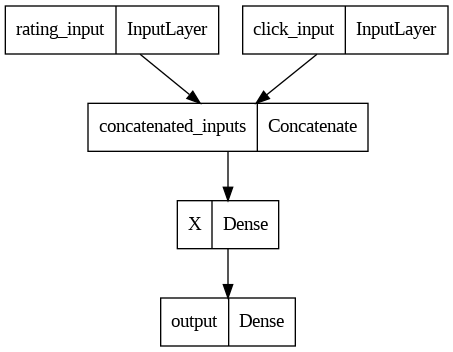

In [ ]:
PHONE_COUNT = 96
model = combine_collaborative_model(128)
# model.summary()
plot_model(model)


In [ ]:
model = combine_collaborative_model(128)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
click_input = train_clicks.to_numpy().T
train_ratings = train_ratings/5
rating_input = train_ratings.to_numpy().T
model.fit([rating_input, click_input], [rating_input, click_input], epochs=30, batch_size=32)


Epoch 1/30
47/47 [==============================] - 1s 2ms/step - loss: 1.0244
Epoch 2/30
47/47 [==============================] - 0s 3ms/step - loss: 0.8731
Epoch 3/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8481
Epoch 4/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8375
Epoch 5/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8308
Epoch 6/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8258
Epoch 7/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8217
Epoch 8/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8184
Epoch 9/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8155
Epoch 10/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8130
Epoch 11/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8109
Epoch 12/30
47/47 [==============================] - 0s 2ms/step - loss: 0.8090
Epoch 13/30
47/47 [==============================

In [ ]:
click_data = [0 for i in range(96)]
# for i in range(52, 58):
#     click_data[i] = 1
for i in range(0, 5):
    click_data[i] = 1


click_data_np = np.array(click_data)
click_data_reshaped = np.reshape(click_data_np, (1,PHONE_COUNT))



rating_data = [0 for i in range(96)]
# for i in range(52, 58):
#     rating_data[i] = 1
for i in range(0, 5):
    rating_data[i] = 5

rating_data = rating_data/5
rating_data_np = np.array(rating_data)
rating_data_reshaped = np.reshape(rating_data_np, (1,PHONE_COUNT))


result = model.predict([rating_data_reshaped, click_data_reshaped])

1/1 [==============================] - 0s 58ms/step


In [ ]:
data_user_clicked = click_data
data_user_rated = rating_data
for i in range(PHONE_COUNT):
    if data_user_clicked[i] != 0 or data_user_rated[i] != 0:
        result[0][i] = 0
result[0] = result[0] / max(result[0])
probability = np.array((result[0]))
df_result = pd.DataFrame()
df_result['probability'] = np.reshape(probability, 96).astype(float)
df_result['name'] = df_phone_dataset['name']
sorted_df_result = df_result.sort_values(by='probability', ascending=False)
sorted_df_result['probability'] = sorted_df_result['probability'] / sorted_df_result['probability'].max()
datas = sorted_df_result.to_numpy()
for i in range(10):
    prob = datas[i][0]
    print(f'{i + 1}. Recommending clicking {prob:0.2f} for phone { (datas[i][1]) }')


1. Recommending clicking 1.00 for phone Vivo V30
2. Recommending clicking 0.99 for phone Vivo V29
3. Recommending clicking 0.94 for phone Oppo A60
4. Recommending clicking 0.93 for phone Infinix Hot 40 Pro
5. Recommending clicking 0.89 for phone Huawei Nova 11 Pro
6. Recommending clicking 0.86 for phone Oppo A18
7. Recommending clicking 0.86 for phone Oppo A38
8. Recommending clicking 0.83 for phone Oppo Reno 10 Pro+
9. Recommending clicking 0.82 for phone Infinix Note 40 Pro
10. Recommending clicking 0.79 for phone iPhone 14


## Eksperimental Section

### Collaborative Filtering for User Rating using Class

In [ ]:
def cost_func_user_ratings(X, W, b, Y, R, lambda_):
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

In [ ]:
def normalizeRatings(Y, R):
    Ymean = (np.sum(Y * R, axis=1)/(np.sum(R, axis=1) + 1e-12)).values.reshape(-1,1)
    Ynorm = Y - np.multiply(Ymean, R)
    return(Ynorm, Ymean)

In [ ]:
R_train_ratings = train_ratings.applymap(lambda x: 1 if x != 0 else 0)
R_train_ratings.head(PHONE_COUNT)

In [ ]:
@tf.keras.utils.register_keras_serializable()
class CollaborativeFilteringModel(tf.keras.Model):
    def __init__(self, num_users, num_items, num_features, lambda_=1, learning_rate=0.01):
        super(CollaborativeFilteringModel, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_features = num_features
        self.lambda_ = lambda_
        self.learning_rate = learning_rate
        
        self.X = tf.Variable(tf.random.normal([num_items, num_features]), dtype=tf.float32, name='X')
        self.W = tf.Variable(tf.random.normal([num_users, num_features]), dtype=tf.float32, name='W')
        self.b = tf.Variable(tf.zeros([num_items, num_users]), dtype=tf.float32, name='b')

    def build(self, input_shape):
        self.built = True

    def call(self, inputs=None):
        if inputs is not None:
            return tf.linalg.matmul(inputs, tf.transpose(self.W)) + self.b
        return tf.linalg.matmul(self.X, tf.transpose(self.W)) + self.b

    def cost_func_user_ratings(self, X, W, b, Y, R):
        j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
        J = 0.5 * tf.reduce_sum(j**2) + (self.lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
        return J

    def train(self, Y, R, epochs=1000):
        optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)

        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                cost = self.cost_func_user_ratings(self.X, self.W, self.b, Y, R)

            grads = tape.gradient(cost, [self.X, self.W, self.b])
            optimizer.apply_gradients(zip(grads, [self.X, self.W, self.b]))

            if epoch % 500 == 0:
                print(f"Training loss at iteration {epoch}: {cost.numpy()}")

    def predict(self, input_data=None):
        if input_data is not None:
            input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
        return self.call(input_data)

    def save_model(self, model_path='collaborative_filtering_model.h5'):
        model_dir = os.path.dirname(model_path)
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        
        tf.keras.models.save_model(self, model_path)

        print(f"Model saved to: {model_path}")
        return 1

    def get_config(self):
        config = {
            'num_users': self.num_users,
            'num_items': self.num_items,
            'num_features': self.num_features,
            'lambda_': self.lambda_,
            'learning_rate': self.learning_rate,
        }
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
Ynorm, Ymean = normalizeRatings(Y = train_ratings, R = R_train_ratings)

In [ ]:
model = CollaborativeFilteringModel(num_users = TOTAL_USER, num_items = PHONE_COUNT, num_features = PHONE_COUNT) #num_features = 100

model.train(Y = Ynorm, R = R_train_ratings, epochs=8000)

predictions = model.predict()
print("Predictions:")
print(predictions.numpy())

Training loss at iteration 0: 571858.5
Training loss at iteration 500: 8711.169921875
Training loss at iteration 1000: 1634.43701171875
Training loss at iteration 1500: 559.5174560546875
Training loss at iteration 2000: 240.76446533203125
Training loss at iteration 2500: 114.05247497558594
Training loss at iteration 3000: 59.514102935791016
Training loss at iteration 3500: 32.30808639526367
Training loss at iteration 4000: 17.165420532226562
Training loss at iteration 4500: 8.525199890136719
Training loss at iteration 5000: 3.8399713039398193
Training loss at iteration 5500: 1.5393729209899902
Training loss at iteration 6000: 0.5439242124557495
Training loss at iteration 6500: 0.1677761971950531
Training loss at iteration 7000: 0.044077713042497635
Training loss at iteration 7500: 0.009300586767494678
Predictions:
[[ 1.2127659e+00  1.2127658e+00  1.2127659e+00 ...  1.2127661e+00
   2.0379023e-36  7.5313438e-37]
 [ 1.0196079e+00 -5.9356134e-35 -4.5477247e-37 ...  1.0196080e+00
   2.4756

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.save('checkpoints/my_model')

'checkpoints/my_model-1'

In [ ]:
new_model = CollaborativeFilteringModel(num_users = TOTAL_USER, num_items = PHONE_COUNT, num_features = PHONE_COUNT) #num_features = 100

new_checkpoint = tf.train.Checkpoint(model=new_model)
new_checkpoint.restore(tf.train.latest_checkpoint('./checkpoints'))


In [ ]:
tf.saved_model.save(model, 'collaborative_filtering_model')

In [ ]:
model.save_weights('collaborative_filtering_model_weights.h5')

In [ ]:
model.save('collaborative_filtering_saved_model')

ValueError: Model <__main__.CollaborativeFilteringModel object at 0x7c83537edc30> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [ ]:
model.save('collaborative_filtering_model.h5')

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [ ]:
model.save('my_collaborative_filtering_model.tf')

ValueError: Model <__main__.CollaborativeFilteringModel object at 0x7c83537edc30> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [ ]:
model.save('collaborative_filtering_model.keras')

In [ ]:
tf.keras.models.save_model(model, 'collaborative_filtering_model_v2.h5')

<ipython-input-24-c97750a89fce>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, 'collaborative_filtering_model_v2.h5')


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [ ]:
loaded_model_keras = tf.keras.models.load_model('collaborative_filtering_model.keras')

In [ ]:
loaded_model_keras = tf.keras.models.load_model('collaborative_filtering_model.keras', custom_objects={'CollaborativeFilteringModel': CollaborativeFilteringModel})

In [ ]:
p = predictions.numpy()

pm = p + Ymean

my_predictions = pm[:, 0]

ix = tf.argsort(my_predictions, direction='DESCENDING')

unrated_predictions = []

# Print top 17 predicted ratings for items not rated by the user
# print("Top Predictions for Unrated Items:")
# for i in range(17):
#     j = ix[i]
#     # Check if the item is not already rated
#     if j not in df_user_ratings_complete[df_user_ratings_complete['user_id'] == MIN_USER_ID]['phone_id'].values:
#         unrated_predictions.append((i, my_predictions[i]))
#         print(f'Predicting rating {my_predictions[j]:0.2f} for phone {j}')

# Save the predictions to a CSV file
# unrated_predictions_df = pd.DataFrame(unrated_predictions, columns=['phone_id', 'predicted_rating'])
# unrated_predictions_df.to_csv('unrated_predictions.csv', index=False)

# print('\n\nOriginal vs Predicted ratings:\n')
# for i in range(len(df_user_ratings_complete[df_user_ratings_complete['user_id'] == MIN_USER_ID])):
#     phone_id = df_user_ratings_complete[(df_user_ratings_complete['user_id'] == MIN_USER_ID)]['phone_id'].values[i]
#     rating = df_user_ratings_complete[(df_user_ratings_complete['user_id'] == MIN_USER_ID) & (df_user_ratings_complete['phone_id'] == phone_id)]['rating'].values[0]
#     if rating > 0:
#         print(f'Original {rating}, Predicted {my_predictions[phone_id]:0.2f} for phone {phone_id}')

data = [0 for _ in range(PHONE_COUNT)]
for i in range(52, 58):
    data[i] = 5

tes = np.array(data)
tes = np.reshape(tes, (1, PHONE_COUNT))

result = model.predict(tes).numpy()

result_mean = result + Ymean

index = 1
check_user = 0

probability = result_mean[check_user]
data_user_rated = data
predictions_list = []

for i in range(PHONE_COUNT):
    # if data_user_rated[i] == 0:
    if True:
        name = df_phone_dataset.iloc[i]['name']
        id = df_phone_dataset.iloc[i]['id']
        # rounded_probability = round(probability[i])
        predictions_list.append((index, probability[i], name, id))
        # predictions_list.append((index, rounded_probability, name, id))
        print(f'{index}. Probability rating {probability[i]:0.5f} for phone {name} id {id}')
        # print(f'{index}. Probability rating {rounded_probability} for phone {name} id {id}')
        index += 1
    else:
        probability[i] = 0

1. Probability rating 5.00000 for phone Oppo Reno 11 Pro id 1
2. Probability rating 5.00000 for phone Oppo Reno 11 id 2
3. Probability rating 5.00000 for phone Oppo Reno 11F id 3
4. Probability rating 3.78723 for phone Oppo Reno 10 id 4
5. Probability rating 5.00000 for phone Oppo Reno 10 Pro id 5
6. Probability rating 5.00000 for phone Oppo Reno 10 Pro+ id 6
7. Probability rating 3.78723 for phone Oppo Find X7 Ultra id 7
8. Probability rating 3.78723 for phone Oppo Find X7 id 8
9. Probability rating 4.00000 for phone Oppo A98 5G id 9
10. Probability rating 3.78723 for phone Oppo A60 id 10
11. Probability rating 5.00000 for phone Oppo Find N3 id 11
12. Probability rating 3.78723 for phone Oppo A79 id 12
13. Probability rating 5.00000 for phone Oppo A18 id 13
14. Probability rating 3.78723 for phone Oppo A38 id 14
15. Probability rating 3.78723 for phone Oppo Pad Neo id 15
16. Probability rating 4.00000 for phone Asus Zenfone 11 Ultra id 16
17. Probability rating 4.00000 for phone Asus 

In [ ]:
def create_collaborative_filtering_model(num_users, num_items, num_features, lambda_=1, learning_rate=0.01):
    # Define inputs
    X_input = tf.keras.layers.Input(shape=(num_items, num_features), name='X_input')
    W_input = tf.keras.layers.Input(shape=(num_users, num_features), name='W_input')
    b_input = tf.keras.layers.Input(shape=(num_items, num_users), name='b_input')

    # Define trainable variables
    X = tf.Variable(tf.random.normal([num_items, num_features]), dtype=tf.float32, name='X')
    W = tf.Variable(tf.random.normal([num_users, num_features]), dtype=tf.float32, name='W')
    b = tf.Variable(tf.zeros([num_items, num_users]), dtype=tf.float32, name='b')

    # Define computation
    pred = tf.linalg.matmul(X_input, tf.transpose(W_input)) + b_input

    # Define cost function
    def cost_func_user_ratings(X, W, b, Y, R):
        j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
        J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
        return J

    # Define training step
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    @tf.function
    def train_step(Y, R):
        with tf.GradientTape() as tape:
            cost = cost_func_user_ratings(X, W, b, Y, R)
        grads = tape.gradient(cost, [X, W, b])
        optimizer.apply_gradients(zip(grads, [X, W, b]))
        return cost

    # Define prediction function
    def predict(input_data):
        return tf.linalg.matmul(input_data, tf.transpose(W)) + b

    # Define saving function
    def save_model(model_path='collaborative_filtering_model.h5'):
        # Ensure the directory exists
        model_dir = os.path.dirname(model_path)
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        # Save the model in H5 format
        model = tf.keras.models.Model(inputs=[X_input, W_input, b_input], outputs=pred)
        model.save(model_path)

        print(f"Model saved to: {model_path}")
        return 1

    return X_input, W_input, b_input, pred, train_step, predict, save_model

def train_model(X_input, W_input, b_input, train_step, Y, R, epochs=1000):
    for epoch in range(epochs):
        cost = train_step(Y, R)
        if epoch % 500 == 0:
            print(f"Training loss at iteration {epoch}: {cost.numpy()}")

In [ ]:
Ynorm, Ymean = normalizeRatings(Y = train_ratings, R = R_train_ratings)

In [ ]:
num_users = TOTAL_USER
num_items = PHONE_COUNT
num_features = PHONE_COUNT
lambda_ = 1
learning_rate = 0.01
Y = Ynorm
R = R_train_ratings

X_input, W_input, b_input, pred, train_step, predict, save_model = create_collaborative_filtering_model(
    num_users, num_items, num_features, lambda_, learning_rate)

train_model(X_input, W_input, b_input, train_step, Y, R, epochs=1000)

ValueError: Exception encountered when calling layer "tf.linalg.matmul" (type TFOpLambda).

Dimensions must be equal, but are 96 and 1507 for '{{node tf.linalg.matmul/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false](Placeholder, Placeholder_1)' with input shapes: [?,96,96], [96,1507,?].

Call arguments received by layer "tf.linalg.matmul" (type TFOpLambda):
  • a=tf.Tensor(shape=(None, 96, 96), dtype=float32)
  • b=tf.Tensor(shape=(96, 1507, None), dtype=float32)
  • transpose_a=False
  • transpose_b=False
  • adjoint_a=False
  • adjoint_b=False
  • a_is_sparse=False
  • b_is_sparse=False
  • output_type=None
  • name=None

In [ ]:
import tensorflow as tf
import os

def collaborative_filtering_model(num_users, num_items, num_features, lambda_=1, learning_rate=0.01):
    # Define inputs
    inputs = tf.keras.Input(shape=(num_items,), dtype=tf.float64)

    # Parameters
    X = tf.Variable(tf.random.normal([num_items, num_features], dtype=tf.float64), name='X')
    W = tf.Variable(tf.random.normal([num_users, num_features], dtype=tf.float64), name='W')
    b = tf.Variable(tf.zeros([num_items, num_users], dtype=tf.float64), name='b')

    # Calculation
    predicted_ratings = tf.linalg.matmul(inputs, tf.transpose(W)) + b

    # Define loss function
    def cost_func_user_ratings(Y, R):
        j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
        J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
        return J

    # Define optimizer
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # Define training step
    @tf.function
    def train_step(Y, R):
        with tf.GradientTape() as tape:
            cost = cost_func_user_ratings(Y, R)
        grads = tape.gradient(cost, [X, W, b])
        optimizer.apply_gradients(zip(grads, [X, W, b]))
        return cost

    # Define prediction function
    def predict(input_data=None):
        if input_data is not None:
            input_data = tf.convert_to_tensor(input_data, dtype=tf.float64)
        return tf.linalg.matmul(input_data, tf.transpose(W)) + b

    # Define save function
    import tensorflow as tf
import os

def collaborative_filtering_model(num_users, num_items, num_features, lambda_=1, learning_rate=0.01):
    # Define inputs
    inputs = tf.keras.Input(shape=(num_items,), dtype=tf.float64)

    # Parameters
    X = tf.Variable(tf.random.normal([num_items, num_features], dtype=tf.float64), name='X')
    W = tf.Variable(tf.random.normal([num_users, num_features], dtype=tf.float64), name='W')
    b = tf.Variable(tf.zeros([num_items, num_users], dtype=tf.float64), name='b')

    # Calculation
    predicted_ratings = tf.linalg.matmul(inputs, tf.transpose(W)) + b

    # Define loss function
    def cost_func_user_ratings(Y, R):
        j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
        J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
        return J

    # Define optimizer
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # Define training step
    @tf.function
    def train_step(Y, R):
        with tf.GradientTape() as tape:
            cost = cost_func_user_ratings(Y, R)
        grads = tape.gradient(cost, [X, W, b])
        optimizer.apply_gradients(zip(grads, [X, W, b]))
        return cost

    # Define prediction function
    def predict(input_data=None):
        if input_data is not None:
            input_data = tf.convert_to_tensor(input_data, dtype=tf.float64)
        return tf.linalg.matmul(input_data, tf.transpose(W)) + b

    # Define save function
    # def save_model(model_path='collaborative_filtering_model.h5'):
    #     model_dir = os.path.dirname(model_path)
    #     if not os.path.exists(model_dir):
    #         os.makedirs(model_dir)
    #     tf.keras.models.save_model((X, W, b), model_path)
    #     print(f"Model saved to: {model_path}")
    #     return 1

    def save_model(path):
        # Create a directory if it doesn't exist
        if not os.path.exists(path):
            os.makedirs(path)

        # Save the model in SavedModel format
        # tf.saved_model.save(model, path)

        # Alternatively, you can save the model in HDF5 format
        model.save(os.path.join(path, 'model.h5'))

    return inputs, predicted_ratings, train_step, predict, save_model

In [ ]:
num_users = TOTAL_USER
num_items = PHONE_COUNT
num_features = PHONE_COUNT
lambda_ = 1
learning_rate = 0.01
Y = Ynorm
R = R_train_ratings
Y = tf.cast(Y, dtype=tf.float64)
R = tf.cast(R, dtype=tf.float64)
epochs = 5000

inputs, predicted_ratings, train_step, predict, save_model = collaborative_filtering_model(num_users, num_items, num_features, lambda_, learning_rate)

for epoch in range(epochs):
    cost = train_step(Y, R)
    if epoch % 100 == 0:
        print(f"Training loss at iteration {epoch}: {cost.numpy()}")

Training loss at iteration 0: 546584.3884454918
Training loss at iteration 100: 50593.550306465615
Training loss at iteration 200: 30960.28414646728
Training loss at iteration 300: 19308.62455724647
Training loss at iteration 400: 12367.81591772676
Training loss at iteration 500: 8141.256804377384
Training loss at iteration 600: 5506.616923033929
Training loss at iteration 700: 3828.8583200152098
Training loss at iteration 800: 2739.0146394468256
Training loss at iteration 900: 2016.758758269212
Training loss at iteration 1000: 1527.533111773084
Training loss at iteration 1100: 1187.7948029781057
Training loss at iteration 1200: 945.0904184797798
Training loss at iteration 1300: 766.2614275968637
Training loss at iteration 1400: 630.2832516902087
Training loss at iteration 1500: 523.8226802715632
Training loss at iteration 1600: 438.42128404990467
Training loss at iteration 1700: 368.67806242732553
Training loss at iteration 1800: 311.0743461705458
Training loss at iteration 1900: 263.

In [ ]:
model.save_model("saved_model")

FileNotFoundError: [Errno 2] No such file or directory: ''

In [ ]:
save_model('collaborative_filtering_model.h5')

### Testing Jason user rating

In [ ]:
p = predictions.numpy()

pm = p + Ymean

my_predictions = pm[:, 0]

ix = tf.argsort(my_predictions, direction='DESCENDING')

unrated_predictions = []

print("Top Predictions for Unrated Items:")
for i in range(20):
    j = ix[i]
    if j not in df_user_ratings_complete[df_user_ratings_complete['user_id'] == MIN_USER_ID]['phone_id'].values:
        # unrated_predictions.append((i, my_predictions[i]))
        print(f'Predicting rating {my_predictions[j]:0.2f} for phone {j}')

# Save the predictions to a CSV file
# unrated_predictions_df = pd.DataFrame(unrated_predictions, columns=['phone_id', 'predicted_rating'])
# unrated_predictions_df.to_csv('unrated_predictions.csv', index=False)

print('\n\nOriginal vs Predicted ratings:\n')
for i in range(len(df_user_ratings_complete[df_user_ratings_complete['user_id'] == MIN_USER_ID])):
    phone_id = df_user_ratings_complete[(df_user_ratings_complete['user_id'] == MIN_USER_ID)]['phone_id'].values[i]
    rating = df_user_ratings_complete[(df_user_ratings_complete['user_id'] == MIN_USER_ID) & (df_user_ratings_complete['phone_id'] == phone_id)]['rating'].values[0]
    if rating > 0:
        print(f'Original {rating}, Predicted {my_predictions[phone_id]:0.2f} for phone {phone_id}')

Top Predictions for Unrated Items:
Predicting rating 5.00 for phone 11
Predicting rating 5.00 for phone 6
Predicting rating 5.00 for phone 0
Predicting rating 4.49 for phone 30
Predicting rating 4.49 for phone 33
Predicting rating 4.47 for phone 10
Predicting rating 4.46 for phone 17
Predicting rating 4.44 for phone 5
Predicting rating 4.37 for phone 93
Predicting rating 4.35 for phone 95
Predicting rating 4.29 for phone 65
Predicting rating 4.26 for phone 27
Predicting rating 4.25 for phone 9
Predicting rating 4.25 for phone 18
Predicting rating 4.23 for phone 84


Original vs Predicted ratings:

Original 4.0, Predicted 4.34 for phone 15
Original 5.0, Predicted 5.00 for phone 2
Original 5.0, Predicted 5.00 for phone 3
Original 5.0, Predicted 4.00 for phone 7
Original 4.0, Predicted 4.00 for phone 14
Original 4.0, Predicted 4.35 for phone 8
Original 5.0, Predicted 3.92 for phone 4
Original 5.0, Predicted 3.91 for phone 12
Original 5.0, Predicted 5.00 for phone 1
Original 4.0, Predicted

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add
from tensorflow.keras.models import Model

def create_collaborative_filtering_model(num_users, num_items, num_features, lambda_=1):
    # Define inputs
    user_input = Input(shape=(1,), name='user_input', dtype='int32')
    item_input = Input(shape=(1,), name='item_input', dtype='int32')

    # Embedding layers
    user_embedding = Embedding(input_dim=num_users, output_dim=num_features, embeddings_initializer='random_normal', name='user_embedding')
    item_embedding = Embedding(input_dim=num_items, output_dim=num_features, embeddings_initializer='random_normal', name='item_embedding')

    # Bias terms
    user_bias = Embedding(input_dim=num_users, output_dim=1, embeddings_initializer='zeros', name='user_bias')
    item_bias = Embedding(input_dim=num_items, output_dim=1, embeddings_initializer='zeros', name='item_bias')

    # Look up embeddings and biases
    user_vecs = Flatten()(user_embedding(user_input))
    item_vecs = Flatten()(item_embedding(item_input))
    user_bias_vecs = Flatten()(user_bias(user_input))
    item_bias_vecs = Flatten()(item_bias(item_input))

    # Compute dot product of user and item embeddings
    dot_product = Dot(axes=1)([user_vecs, item_vecs])

    # Add bias terms
    output = Add()([dot_product, user_bias_vecs, item_bias_vecs])

    # Build the model
    model = Model(inputs=[user_input, item_input], outputs=output)

    return model

def custom_loss(lambda_, user_embedding, item_embedding):
    def loss(y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
        squared_error = tf.square(y_true - y_pred) * mask
        mse = tf.reduce_sum(squared_error) / tf.reduce_sum(mask)
        regularization = (lambda_ / 2) * (tf.reduce_sum(tf.square(user_embedding.weights[0])) + tf.reduce_sum(tf.square(item_embedding.weights[0])))
        return mse + regularization
    return loss


# lambda_ = 1

# Create model
# model = create_collaborative_filtering_model(TOTAL_USER, PHONE_COUNT, PHONE_COUNT, lambda_)

# Compile the model with the custom loss function
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss(lambda_, model.get_layer('user_embedding'), model.get_layer('item_embedding')))

# Assuming Y and R are your rating and mask matrices
# Y = ...
# R = ...

# Prepare training data
indices = tf.where(R_train_ratings == 1)
user_ids = indices[:, 0]
item_ids = indices[:, 1]
y_true = tf.gather_nd(Ynorm, indices)

# # Check the maximum values of user_ids and item_ids
# max_user_id = tf.reduce_max(user_ids).numpy()
# max_item_id = tf.reduce_max(item_ids).numpy()

# print(f"Max user ID: {max_user_id}, Max item ID: {max_item_id}")

# # Ensure num_users and num_items are greater than the maximum IDs
# assert max_user_id < TOTAL_USER, f"num_users should be greater than {max_user_id}"
# assert max_item_id < PHONE_COUNT, f"num_items should be greater than {max_item_id}"

# Train the model
# model.fit([user_ids, item_ids], y_true, epochs=1000, batch_size=32, verbose=2)

# # Predict for user 0 and item 0
# prediction = model.predict([tf.constant([0]), tf.constant([0])])
# print("Prediction:", prediction[0][0])

# Determine the number of users and items
num_users = tf.reduce_max(user_ids).numpy() + 1
num_items = tf.reduce_max(item_ids).numpy() + 1
num_features = 10
lambda_ = 1
learning_rate = 0.01

print(f"Number of users: {num_users}, Number of items: {num_items}")

# Create model
model = create_collaborative_filtering_model(num_users, num_items, num_features, lambda_)

# Compile the model with the custom loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=custom_loss(lambda_, model.get_layer('user_embedding'), model.get_layer('item_embedding')), metrics=['accuracy'])

# Train the model
model.fit([user_ids, item_ids], y_true, epochs=1000, batch_size=32, verbose=2)

# Predict for user 0 and item 0
prediction = model.predict([tf.constant([0]), tf.constant([0])])
print("Prediction:", prediction[0][0])

Number of users: 96, Number of items: 1507
Epoch 1/1000
327/327 - 1s - loss: 1.0514 - accuracy: 0.0000e+00 - 1s/epoch - 4ms/step
Epoch 2/1000
327/327 - 1s - loss: 0.7277 - accuracy: 0.0000e+00 - 847ms/epoch - 3ms/step
Epoch 3/1000


KeyboardInterrupt: 

### Contoh model 2 (TAK JADI)

In [ ]:
# Collaborative Filtering Model
class CollaborativeFilteringModels(tf.Module):
    def __init__(self, num_users, num_items, num_features, lambda_):
        # Initialize model parameters
        self.num_users = num_users
        self.num_items = num_items
        self.num_features = num_features
        self.lambda_ = lambda_

        # Initialize user and item feature matrices with random values
        self.X = tf.Variable(tf.random.normal([num_items, num_features]), name='X')
        self.W = tf.Variable(tf.random.normal([num_users, num_features]), name='W')

        # Initialize bias terms
        self.b = tf.Variable(tf.random.normal([num_items, num_users]), name='b')

    def __call__(self, Y, R):
        return cost_func_user_ratings(self.X, self.W, self.b, Y, R, self.lambda_)

    # Training function
    # def train_model(model, Y, R, learning_rate, num_epochs):
    #     optimizer = tf.optimizers.Adam(learning_rate)

    #     for epoch in range(num_epochs):
    #         with tf.GradientTape() as tape:
    #             cost = model(Y, R)

    #         # Compute gradients
    #         gradients = tape.gradient(cost, [model.X, model.W, model.b])

    #         # Apply gradients to optimize the parameters
    #         optimizer.apply_gradients(zip(gradients, [model.X, model.W, model.b]))

    #         if epoch % 100 == 0 or epoch == num_epochs - 1:
    #             print(f'Epoch {epoch + 1}, Cost: {cost.numpy()}')

    def train_model(self, Y, R, learning_rate, num_epochs):
        optimizer = tf.optimizers.Adam(learning_rate)

        for epoch in range(num_epochs):
            with tf.GradientTape() as tape:
                cost = model(Y, R)

            # Compute gradients
            gradients = tape.gradient(cost, [model.X, model.W, model.b])

            # Apply gradients to optimize the parameters
            optimizer.apply_gradients(zip(gradients, [model.X, model.W, model.b]))

            if epoch % 20 == 0 or epoch == num_epochs - 1:
                print(f'Training loss at iteration {epoch}: {cost.numpy()}')

    def predict(self):
        return tf.linalg.matmul(self.X, tf.transpose(self.W)) + self.b

In [ ]:
model = CollaborativeFilteringModels(num_users = TOTAL_USER, num_items = PHONE_COUNT, num_features = 100, lambda_ = 1)

model.train_model(Y = train_ratings, R = R_train_ratings, learning_rate = 0.01, num_epochs = 5000)

predictions = model.predict()
print("Predictions:")
print(predictions.numpy())

In [ ]:
# Make a prediction using trained weights and biases
p = predictions.numpy()

# Restore the mean
pm = p + train_ratings.mean().values

my_predictions = pm[:, 0]

# Sort predictions
ix = tf.argsort(my_predictions, direction='DESCENDING')

# Print top 17 predicted ratings for items not rated by the user
print("Top Predictions for Unrated Items:")
for i in range(17):
    j = ix[i]
    # Check if the item is not already rated
    if j not in df_user_ratings_complete[df_user_ratings_complete['user_id'] == MIN_USER_ID]['phone_id'].values:
        print(f'Predicting rating {my_predictions[j]:0.2f} for phone {j}')

print('\n\nOriginal vs Predicted ratings:\n')
for i in range(len(df_user_ratings_complete[df_user_ratings_complete['user_id'] == MIN_USER_ID])):
    phone_id = df_user_ratings_complete[(df_user_ratings_complete['user_id'] == MIN_USER_ID)]['phone_id'].values[i]
    rating = df_user_ratings_complete[(df_user_ratings_complete['user_id'] == MIN_USER_ID) & (df_user_ratings_complete['phone_id'] == phone_id)]['rating'].values[0]
    if rating > 0:
        print(f'Original {rating}, Predicted {my_predictions[phone_id]:0.2f} for phone {phone_id}')

### Salah

In [ ]:
def collaborative_filtering_model(num_users, num_items, num_features, lambda_, learning_rate=0.001, num_epochs=1000):

    tf.compat.v1.disable_eager_execution()
    # Initialize the variables
    X = tf.Variable(tf.random.normal([num_items, num_features], stddev=0.35), name='X')
    W = tf.Variable(tf.random.normal([num_users, num_features], stddev=0.35), name='W')
    b = tf.Variable(tf.random.normal([num_items, num_users], stddev=0.35), name='b')

    # Placeholder for the true ratings and the R matrix
    Y = tf.compat.v1.placeholder(tf.float32, shape=[num_items, num_users], name='Y')
    R = tf.compat.v1.placeholder(tf.float32, shape=[num_items, num_users], name='R')

    # Cost function
    def cost_func_user_ratings(X, W, b, Y, R, lambda_):
        j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
        J = 0.5 * tf.reduce_sum(tf.square(j)) + (lambda_/2) * (tf.reduce_sum(tf.square(X)) + tf.reduce_sum(tf.square(W)))
        return J

    # Define the cost function
    cost = cost_func_user_ratings(X, W, b, Y, R, lambda_)

    # Optimizer
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(cost)

    # Initialize all variables
    init = tf.compat.v1.global_variables_initializer()

    # Function to train the model
    def train_model(Y_train, R_train, num_epochs=num_epochs):
        with tf.compat.v1.Session() as sess:
            sess.run(init)
            for epoch in range(num_epochs):
                _, current_cost = sess.run([optimizer, cost], feed_dict={Y: Y_train, R: R_train})
                if epoch % 100 == 0:
                    print(f"Epoch {epoch}, Cost: {current_cost}")

            # Get the trained values of X, W, and b
            trained_X = sess.run(X)
            trained_W = sess.run(W)
            trained_b = sess.run(b)

        return trained_X, trained_W, trained_b

    def predict_ratings(trained_X, trained_W, trained_b, user_ratings, N=5):
        # Predict ratings for the user
        predicted_ratings = np.dot(trained_X, trained_W.T) + trained_b

        # Get the predicted ratings for the specified user
        user_predicted_ratings = predicted_ratings[:, user_id - 1]  # Subtract 1 to account for 0-based indexing of user ID

        # Filter out the ratings for items that the user has already rated
        user_predicted_ratings_filtered = np.where(R_user == 0, user_predicted_ratings, 0)

        # Get the indices of the top recommended items
        top_recommendations_indices = np.argsort(user_predicted_ratings_filtered)[::-1][:N]  # Replace N with the number of top recommendations desired

        return top_recommendations_indices, user_predicted_ratings_filtered

    return train_model, predict_ratings

In [ ]:
model = collaborative_filtering_model(TOTAL_USER, PHONE_COUNT, 100, 1, learning_rate=0.001, num_epochs=5000)

trained_X, trained_W, trained_b = model(train_ratings, R_train_ratings)

In [ ]:
# Functional model definition for collaborative filtering using clicks
def collaborative_model_ratings_functional(num_features):
    # Input layer for user clicks
    rating_input = tf.keras.Input(shape=(PHONE_COUNT,), dtype=tf.float32, name='user_input')

    # Embedding layer for user clicks
    user_embedding = tf.keras.layers.Dense(units=num_features, activation=None, kernel_initializer='random_normal', name='user_embedding')(rating_input)

    # Output layer
    output = tf.keras.layers.Dense(PHONE_COUNT, activation='softmax', name='output')(user_embedding)

    # Define the model
    model = tf.keras.Model(inputs=rating_input, outputs=output, name='collaborative_model_ratings')

    return model

In [ ]:
num_features = 10  # Example number of features
model = collaborative_model_ratings_functional(num_features)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Convert the training data to the required format for model input
train_data = train_ratings.to_numpy().T

# Train the model
model.fit(train_data, train_data, epochs=50, batch_size=32)

In [ ]:
result = model.predict(train_data)
print(result[0])

In [ ]:
df_result = pd.DataFrame()
df_result['probability'] = np.reshape(result[0], 96).astype(float)
df_result['name'] = df_phone_dataset['name']
sorted_df_result = df_result.sort_values(by='probability', ascending=False)
# sorted_df_result = sorted_df_result[sorted_df_result['probability'] <= 5]
# sorted_df_result['probability'] = sorted_df_result['probability'] / sorted_df_result['probability'].max()
datas = sorted_df_result.to_numpy()
for i in range(10):
    prob = datas[i][0]
    print(f'{i + 1}. Probability rating {prob:0.2f} for phone { (datas[i][1]) }')

### Collaborative  Filtering for User Click

In [ ]:
def cost_func_user_clicks(X, W, b, Y, lambda_):
    # j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)
    b = tf.reshape(b, (TOTAL_USER))
    j = (tf.linalg.matmul(X, tf.transpose(W)))
    j = j + b - Y
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

In [ ]:
def collaborative_model_clicks(num_features):
    W = tf.keras.layers.Embedding(input_dim=TOTAL_USER, output_dim=num_features, embeddings_initializer='random_normal', name='W')
    X = tf.keras.layers.Embedding(input_dim=PHONE_COUNT, output_dim=num_features, embeddings_initializer='random_normal', name='X')
    b = tf.keras.layers.Embedding(input_dim=TOTAL_USER, output_dim=1, embeddings_initializer='random_normal', name='b')

    user_input = tf.keras.Input(shape=(TOTAL_USER,), dtype=tf.int32, name='user_input')
    phone_input = tf.keras.Input(shape=(PHONE_COUNT,), dtype=tf.int32, name='phone_input')

    user_embedding = W(user_input)
    phone_embedding = X(phone_input)
    user_bias = b(user_input)

    dot_product = tf.keras.layers.Dot(axes=-1)([user_embedding, phone_embedding])
    output = tf.keras.layers.Add()([dot_product, user_bias])
    output = tf.keras.layers.Lambda(lambda x: tf.where(x > 0.9, 0.0, x))(output)
    output = tf.keras.layers.Dense(PHONE_COUNT, activation='sigmoid')(output)

    model = tf.keras.Model(inputs=[user_input, phone_input], outputs=output, name='collaborative_model_clicks')

    return model

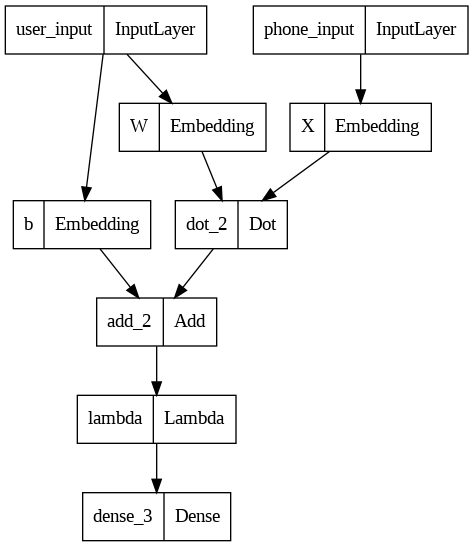

In [ ]:
model = collaborative_model_clicks(100)
tf.keras.utils.plot_model(model)
# model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


iterations = 200
lambda_ = 1

# Convert model layers to variables for custom training
W_var = model.get_layer('W').embeddings
X_var = model.get_layer('X').embeddings
b_var = model.get_layer('b').embeddings
input_2 = train_clicks.to_numpy()

for iter in range(iterations):
    with tf.GradientTape() as tape:
        cost_value = cost_func_user_clicks(X_var, W_var, b_var, input_2, lambda_)

    grads = tape.gradient(cost_value, [W_var, X_var, b_var])
    optimizer.apply_gradients(zip(grads, [W_var, X_var, b_var]))

    if iter % 20 == 0:
        print(f"Training loss at iteration {iter}: {cost_value.numpy():0.4f}")

Training loss at iteration 0: 5420.6079
Training loss at iteration 20: 1450.2887
Training loss at iteration 40: 871.8950
Training loss at iteration 60: 704.9508
Training loss at iteration 80: 657.0974
Training loss at iteration 100: 638.5234
Training loss at iteration 120: 630.9617
Training loss at iteration 140: 627.3366
Training loss at iteration 160: 625.2599
Training loss at iteration 180: 623.9636


In [ ]:
W_var = model.get_layer('W').embeddings
X_var = model.get_layer('X').embeddings
b_var = model.get_layer('b').embeddings

p = np.matmul(X_var.numpy(), np.transpose(W_var.numpy())) + np.reshape(b_var.numpy(), (TOTAL_USER))

user_id = 5

probability = p[:, user_id]


In [ ]:
index = 1
for i in range(PHONE_COUNT):
    if probability[i] > 0.5:
        name =  df_phone_dataset.iloc[i]['name']
        id =  df_phone_dataset.iloc[i]['id']
        print(f'{index}. Predicted clicked is {probability[i]:0.2f} for phone { name } id { id }')
        index += 1

1. Predicted clicked is 0.86 for phone Oppo Reno 11 Pro id 1
2. Predicted clicked is 0.88 for phone Oppo Reno 11F id 3
3. Predicted clicked is 0.93 for phone Oppo Reno 10 Pro+ id 6
4. Predicted clicked is 0.91 for phone Oppo Find X7 Ultra id 7
5. Predicted clicked is 0.90 for phone Oppo A98 5G id 9
6. Predicted clicked is 0.82 for phone Oppo A18 id 13
7. Predicted clicked is 0.89 for phone Oppo Pad Neo id 15
8. Predicted clicked is 0.84 for phone Infinix Hot 40 Pro id 26
9. Predicted clicked is 0.82 for phone Vivo V29 id 50
10. Predicted clicked is 0.85 for phone Huawei Nova 12 SE id 55


In [ ]:
df_result = pd.DataFrame()
df_result['probability'] = probability
df_result['name'] = df_phone_dataset['name']
sorted_df_result = df_result.sort_values(by='probability', ascending=False)
sorted_df_result = sorted_df_result[sorted_df_result['probability'] <= 0.5]
sorted_df_result['probability'] = sorted_df_result['probability'] / sorted_df_result['probability'].max()

datas = sorted_df_result.to_numpy()
for i in range(30):
    prob = datas[i][0]
    print(f'{i + 1}. Probability click is {prob:0.2f} for phone { (datas[i][1]) }')

1. Probability click is 1.00 for phone Oppo Reno 11
2. Probability click is 0.96 for phone Oppo Find N3
3. Probability click is 0.88 for phone Oppo A60
4. Probability click is 0.83 for phone Oppo Reno 10
5. Probability click is 0.64 for phone Oppo A79
6. Probability click is 0.63 for phone Oppo Find X7
7. Probability click is 0.61 for phone Oppo A38
8. Probability click is 0.58 for phone Oppo Reno 10 Pro
9. Probability click is 0.56 for phone Vivo T3x
10. Probability click is 0.53 for phone Asus Zenfone 11 Ultra
11. Probability click is 0.51 for phone Infinix Smart 8
12. Probability click is 0.51 for phone Huawei Nova 11 Pro
13. Probability click is 0.50 for phone Vivo V30e
14. Probability click is 0.48 for phone Infinix Note 40 Pro
15. Probability click is 0.41 for phone Vivo Y100
16. Probability click is 0.39 for phone iPhone 12
17. Probability click is 0.36 for phone Vivo V30 Pro
18. Probability click is 0.35 for phone Poco X6 Pro 5G
19. Probability click is 0.34 for phone iPhone 15